In [1]:
print("Hello, World! ^_^ ")

Hello, World! ^_^ 


# Activate Environment and import necessary modules

In [2]:
!source /Users/amirejibiilia/Desktop/Thesis/new_venv/bin/activate

In [3]:
import time
import numpy as np
import pandas as pd 

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, train_test_split # Model evaluation
from sklearn.preprocessing import MinMaxScaler # Data normalization

from xgboost import XGBRegressor, DMatrix, plot_importance # XGBoost

import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

import matplotlib.dates as mdates
import optuna
from sklearn.metrics import mean_squared_error

2024-06-21 00:11:54.374861: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# data import
df_train = pd.read_excel("/Users/amirejibiilia/Desktop/Thesis/version_4.xlsx", index_col = 0) 
cols_list = list(df_train.columns) 

In [5]:
df_train.head().round(2)

,HousingIndex,Capitalisation,ExchangeRate,InterestRateOnDeposits,CPI,HouseAffordabilityIndex,RentIndex,MortgageRate
Date,,,,,,,,
2005-01-01,163.43,8.53,1.82,7.66,102.09,40.0,111.90,0.16
2005-02-01,159.72,9.56,1.83,7.49,100.32,40.0,122.59,0.16
2005-03-01,178.20,8.62,1.84,7.04,100.59,40.0,123.29,0.16
2005-04-01,183.23,8.81,1.83,7.08,100.42,40.0,129.64,0.16
2005-05-01,175.51,9.45,1.83,7.58,98.71,40.0,133.09,0.16


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 230 entries, 2005-01-01 to 2024-02-29
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   HousingIndex             230 non-null    float64
 1   Capitalisation           230 non-null    float64
 2   ExchangeRate             230 non-null    float64
 3   InterestRateOnDeposits   230 non-null    float64
 4   CPI                      230 non-null    float64
 5   HouseAffordabilityIndex  230 non-null    float64
 6   RentIndex                230 non-null    float64
 7   MortgageRate             230 non-null    float64
dtypes: float64(8)
memory usage: 16.2 KB


In [7]:
df_train.describe().round(2)

,HousingIndex,Capitalisation,ExchangeRate,InterestRateOnDeposits,CPI,HouseAffordabilityIndex,RentIndex,MortgageRate
count,230.00,230.00,230.00,230.00,230.00,230.00,230.00,230.00
mean,336.60,8.49,2.18,7.38,100.42,97.92,231.91,0.12
std,96.23,1.13,0.56,1.78,1.01,37.87,88.82,0.03
min,159.07,6.61,1.40,4.06,95.96,40.00,111.90,0.06
25%,267.76,7.71,1.68,5.84,99.86,62.14,170.51,0.09
50%,315.28,8.29,1.83,7.50,100.32,100.03,212.76,0.11
75%,386.71,9.11,2.66,8.57,100.86,134.87,262.56,0.16
max,566.67,11.95,3.44,11.66,104.19,155.52,497.86,0.17


# Exploratory Data Analysis

## display Missing values

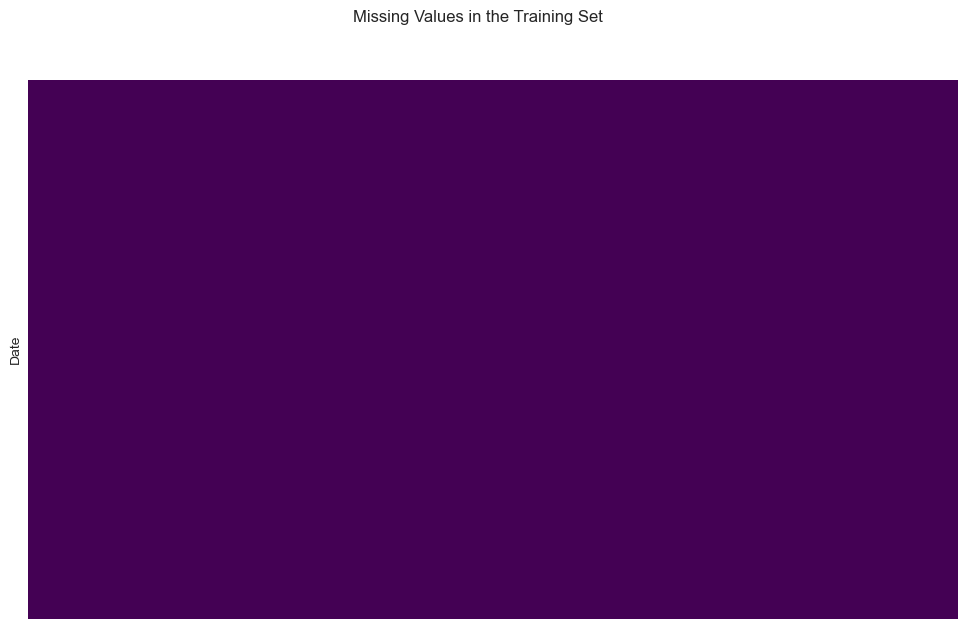

In [8]:
label_nas = []
for col in df_train.columns.tolist():
    if np.sum(df_train[col].isnull() ) != 0:
        label_nas.append(col)
    else:
        label_nas.append("")

plt.figure(figsize=(12,7))
plt.suptitle('Missing Values in the Training Set')
sns.heatmap(df_train.isnull(), yticklabels=False, xticklabels=label_nas ,cbar = False, cmap='viridis')
plt.show()

## Data Correlation Analysis

In [9]:
# Correlation matrix
corr_mat = df_train.corr()

# Find most Correlated features relative to HousingIndex
corr_mat.sort_values(by=["HousingIndex"], ascending = False, inplace = True)
# print(corr_mat.HousingIndex.round(2))
data_frame_corr_mat = pd.DataFrame(corr_mat.HousingIndex.round(2))
data_frame_corr_mat

,HousingIndex
HousingIndex,1.00
RentIndex,0.91
HouseAffordabilityIndex,0.84
ExchangeRate,0.84
Capitalisation,0.29
CPI,0.01
InterestRateOnDeposits,-0.35
MortgageRate,-0.71


In [10]:
#Correlation matrix between features
corr_mat = df_train.corr()

<Axes: >

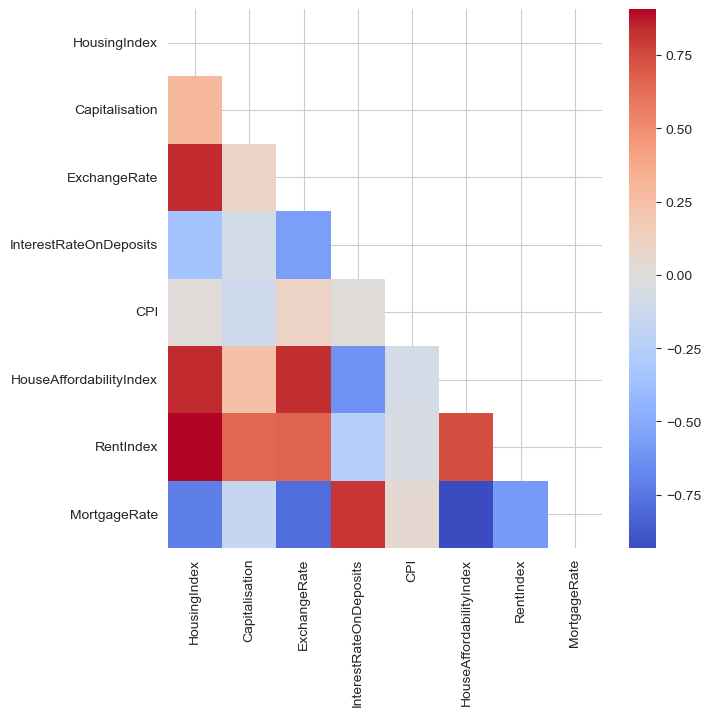

In [11]:
#Plot the heatmap with seaborn
plt.figure(figsize=(7,7)) 

mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_mat, mask=mask, cmap = 'coolwarm',
        xticklabels=corr_mat.columns,
        yticklabels=corr_mat.columns)

## Skewness

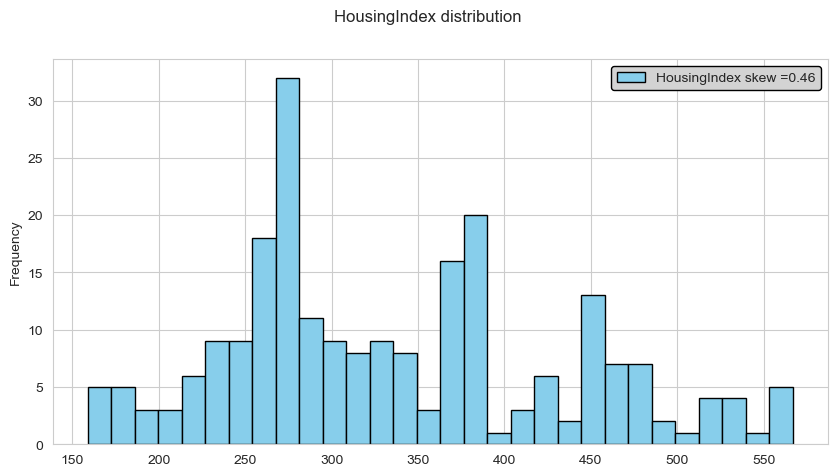

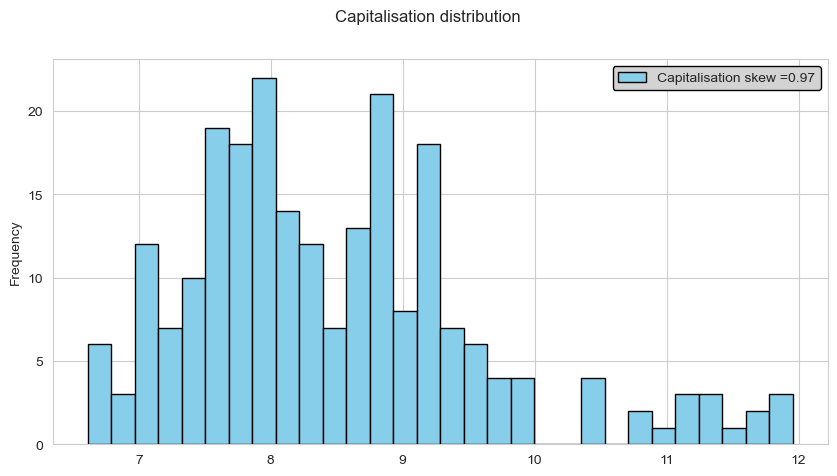

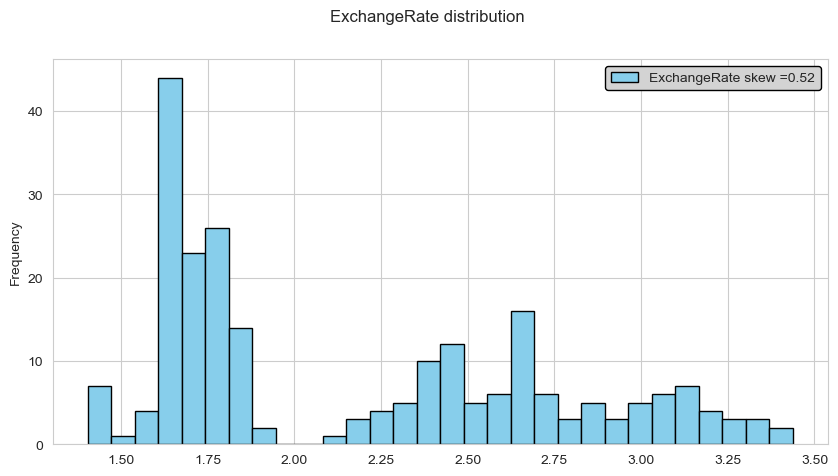

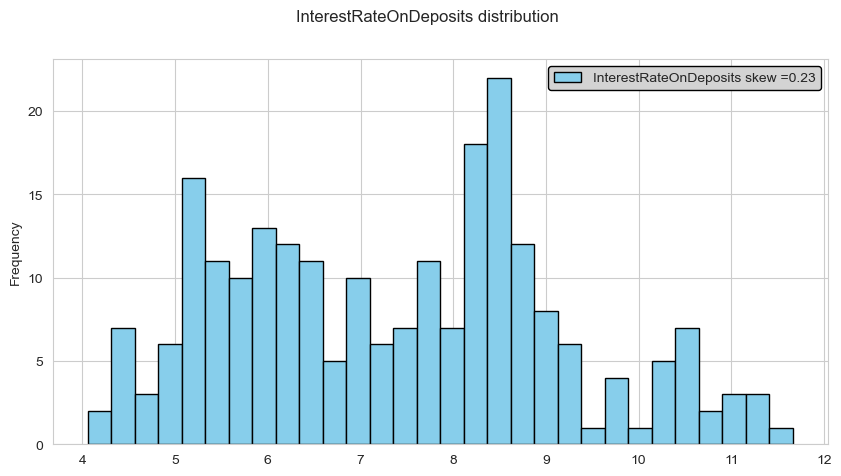

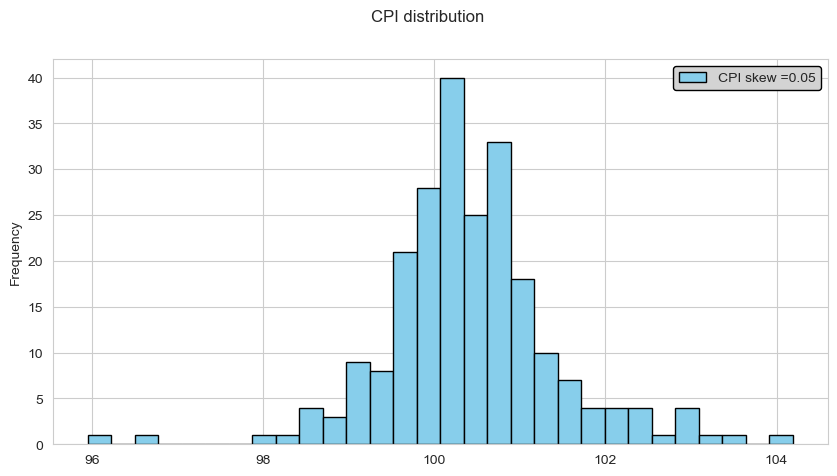

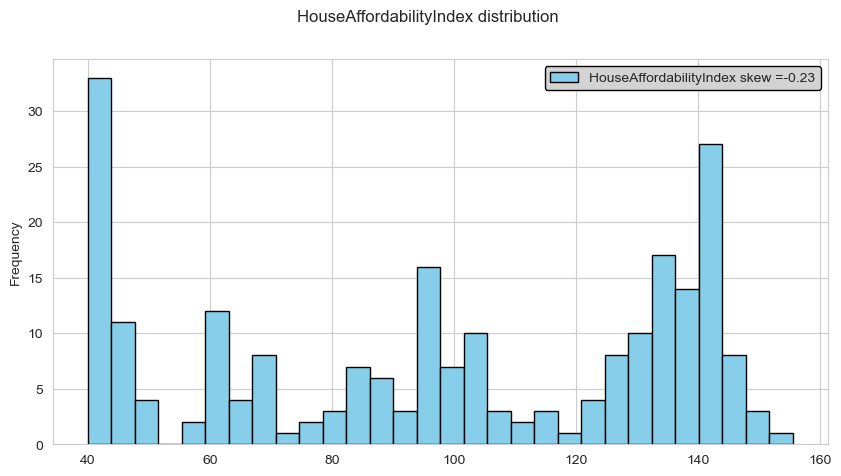

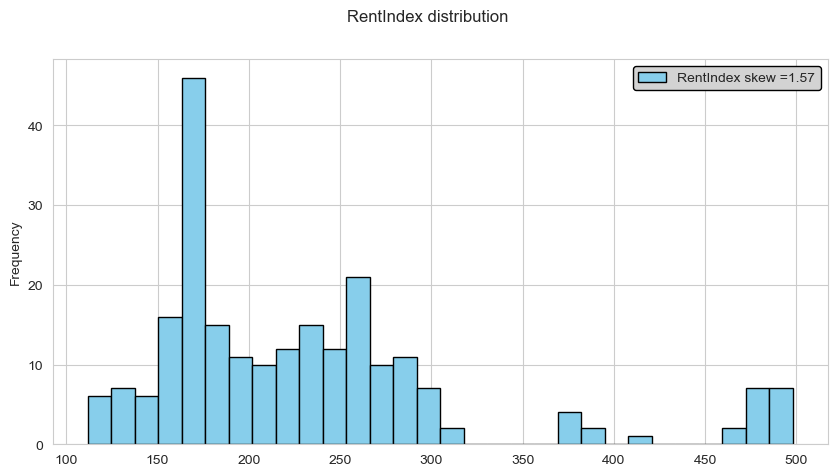

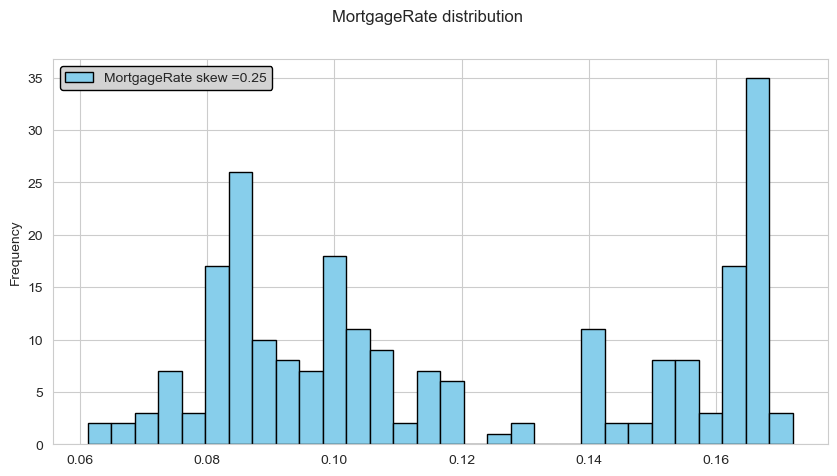

In [12]:
# Check the skewness of HousingIndex
for col in cols_list:
    plt.figure(figsize=(10, 5))
    skewness = df_train[col].skew()
    df_train[col].plot.hist(edgecolor='black', bins=30, 
                            label=col + ' skew =' + str(round(skewness, 2)), 
                            color='skyblue')
    plt.suptitle("{} distribution".format(col))
    plt.legend(edgecolor='black', facecolor='lightgrey', framealpha=1)
    plt.show()



## Box plots

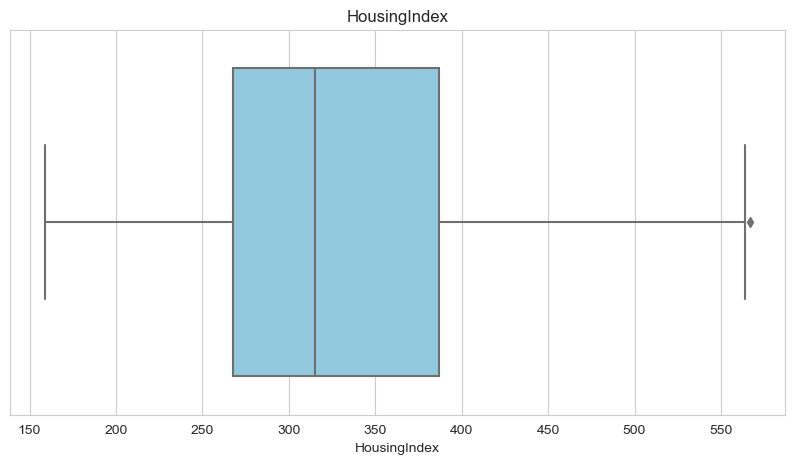

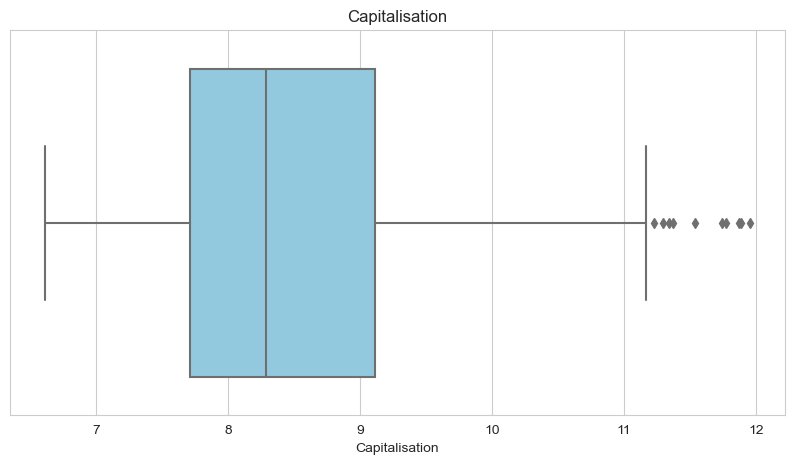

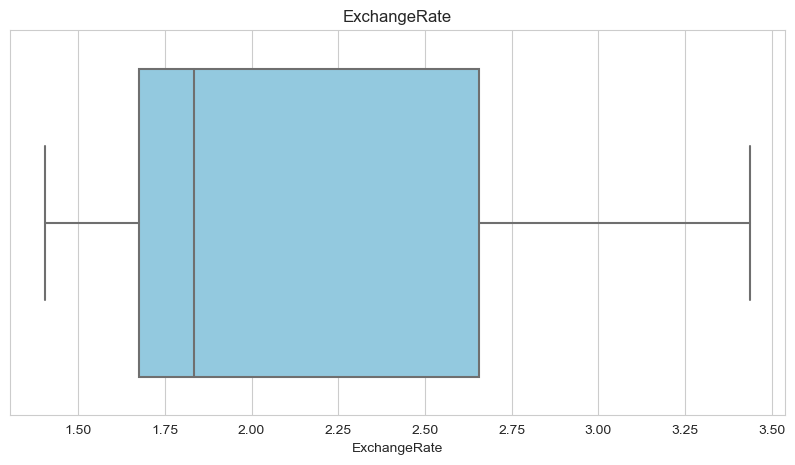

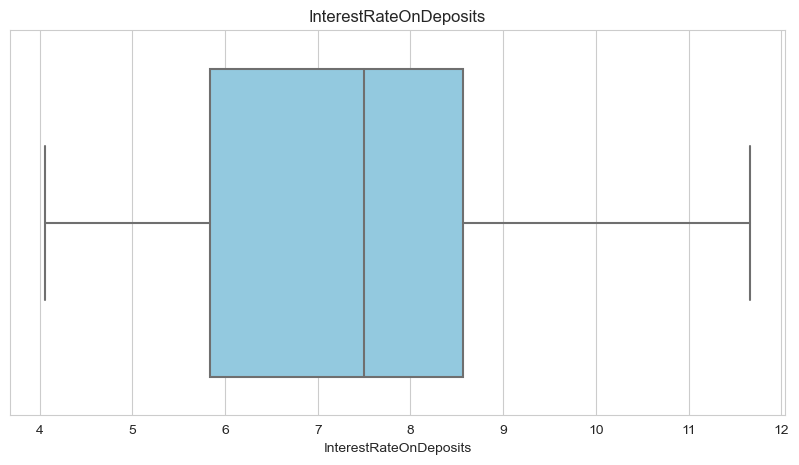

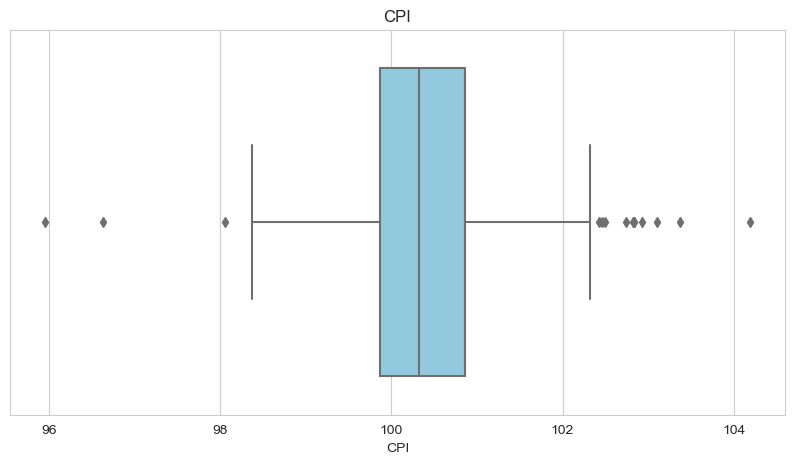

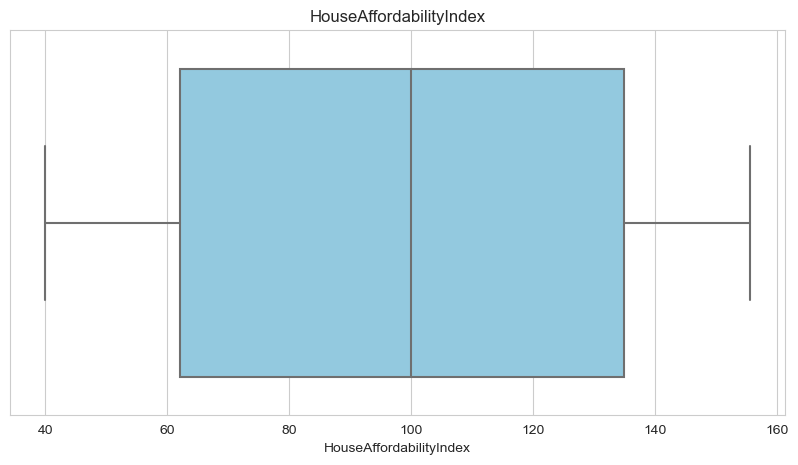

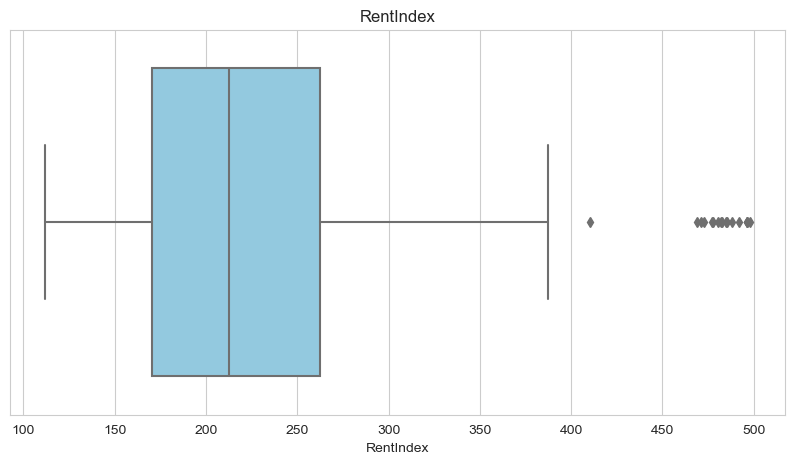

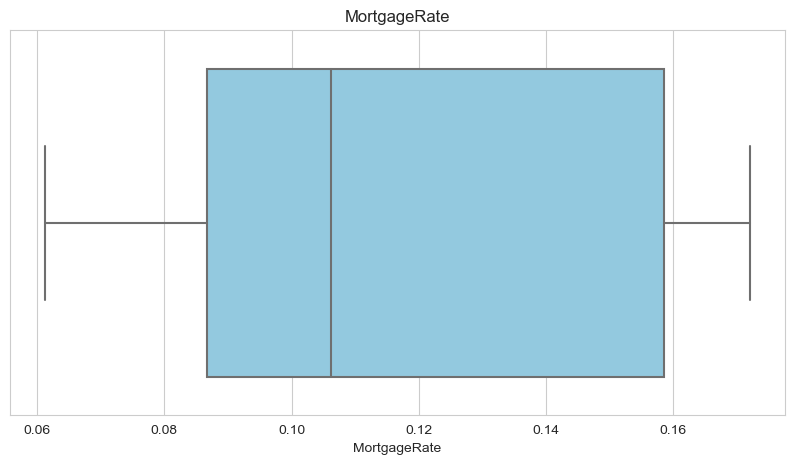

In [13]:
for col in cols_list:
    plt.figure(figsize=(10, 5))
    ax = sns.boxplot(x=col, data=df_train, color='skyblue')
    ax.set_title(col)
    plt.show()

## Features and Trend

In [14]:
df_train_vis = pd.read_excel("/Users/amirejibiilia/Desktop/Thesis/version_4.xlsx") 
cols_list_vis = list(df_train_vis.columns) 

In [15]:
# Convert 'Date' column to matplotlib numeric format
df_train_vis['Date'] = df_train_vis['Date'].apply(mdates.date2num)

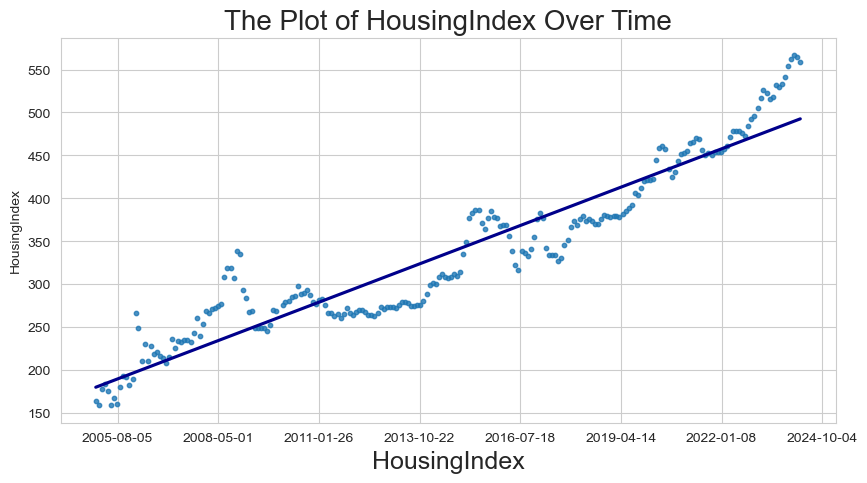

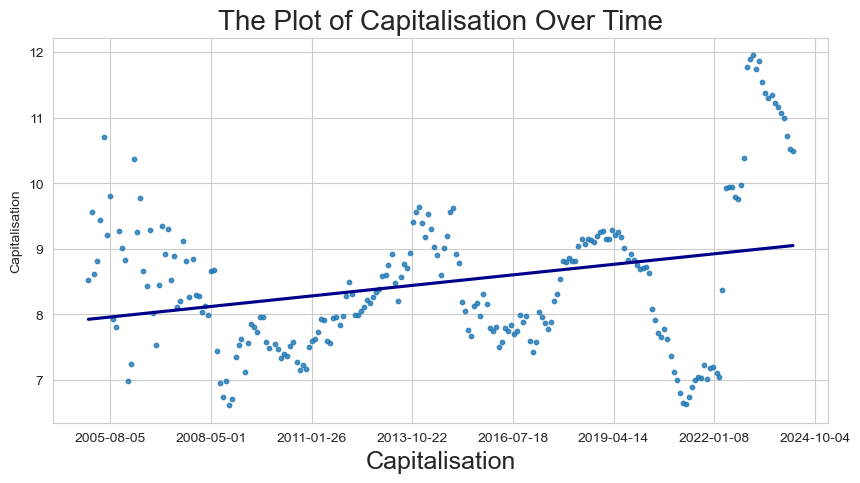

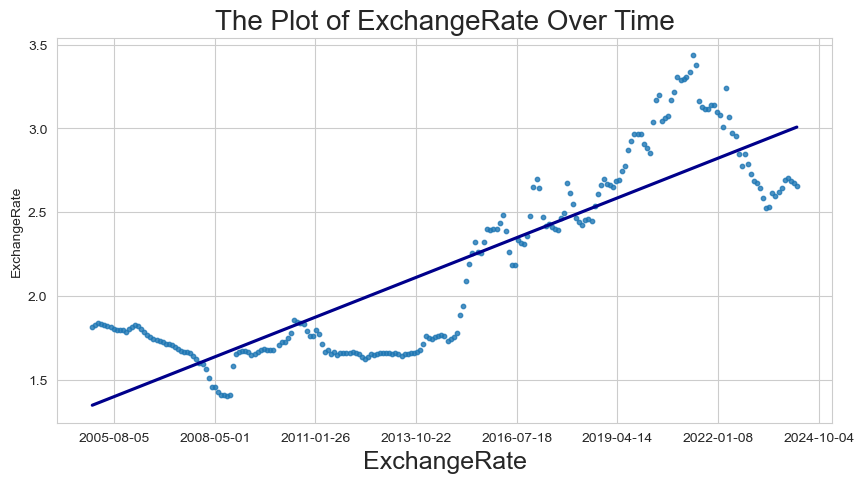

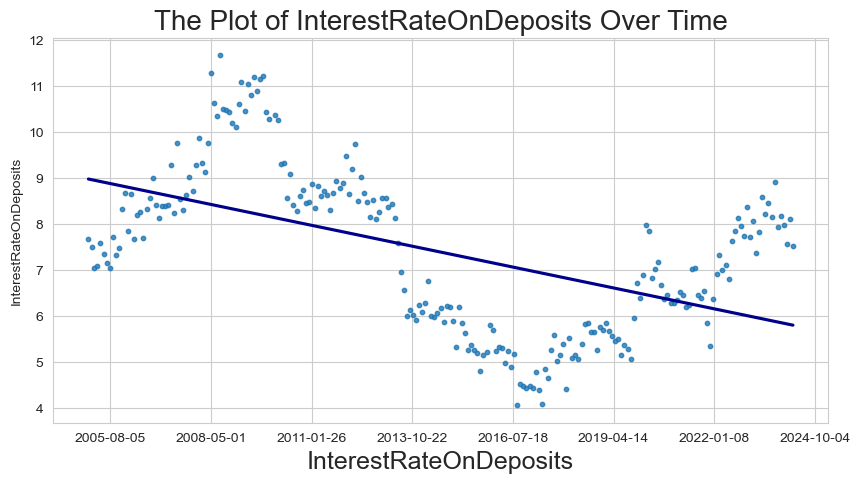

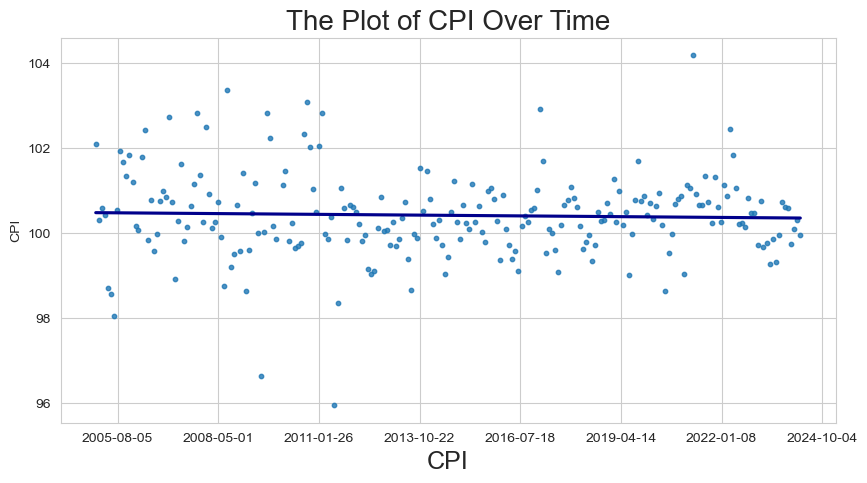

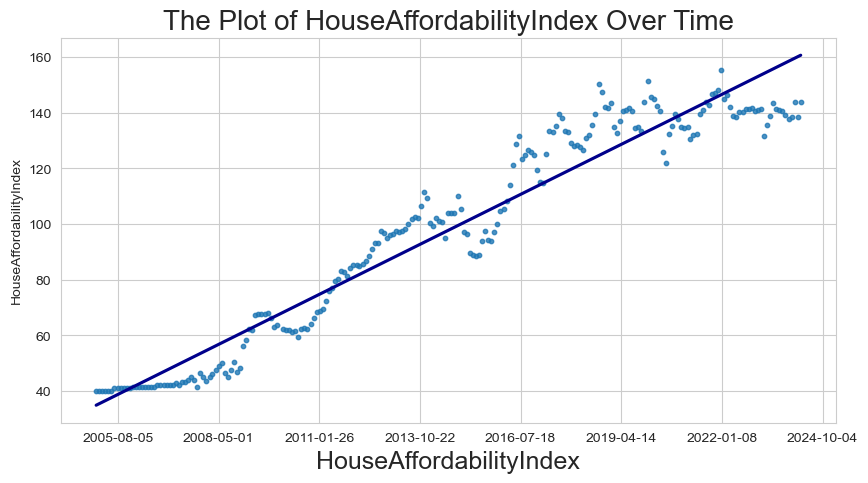

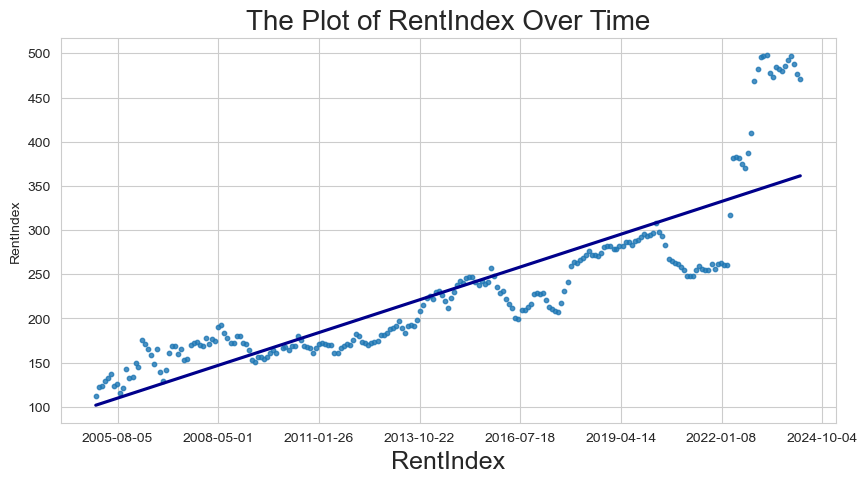

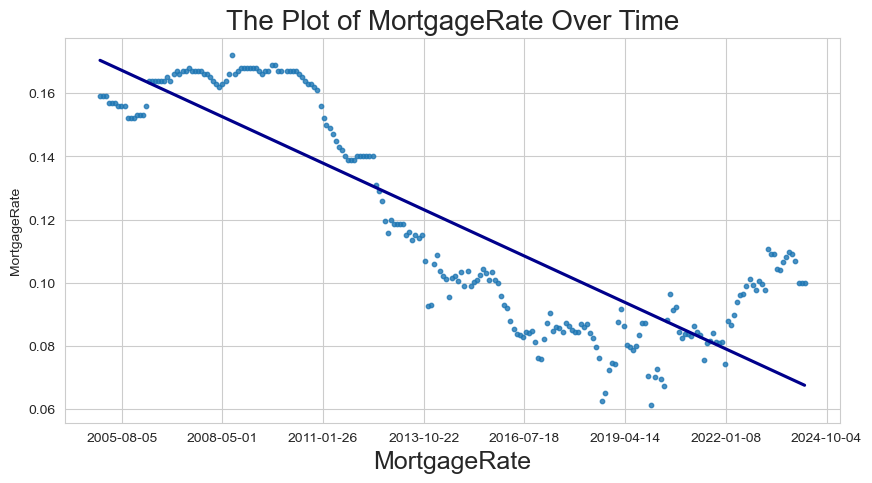

In [16]:
for col in cols_list:
    x_axis = 'Date'
    y_axis = col

    # Proceed with plotting
    plt.figure(figsize=(10, 5))
    sns.regplot(x=x_axis, y=y_axis, data=df_train_vis, fit_reg=True, ci=None, 
                scatter_kws={'s': 10},               
                line_kws={'color': 'darkblue'})      
    plt.title('The Plot of {} Over Time'.format(y_axis), fontsize=20)
    plt.xlabel(format(y_axis), fontsize=18)
    plt.grid(True)

    # Customize x-axis tick labels to display dates
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=0)
    plt.show()


## HousingIndex vs other Features

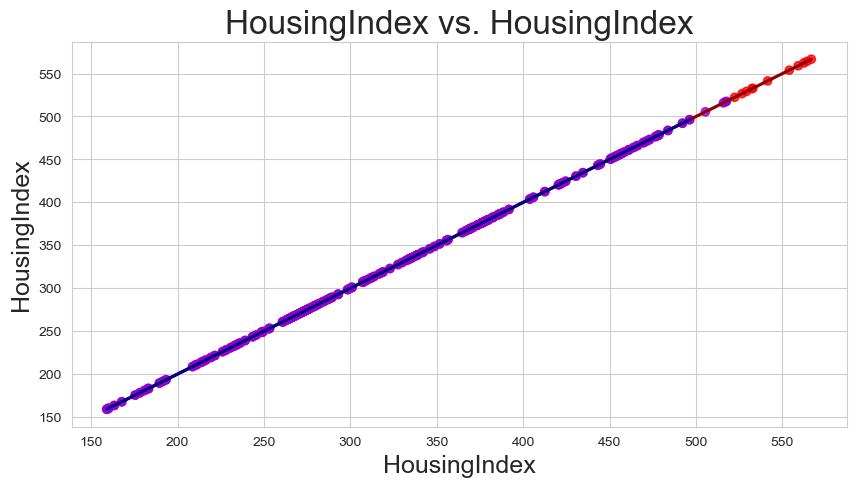

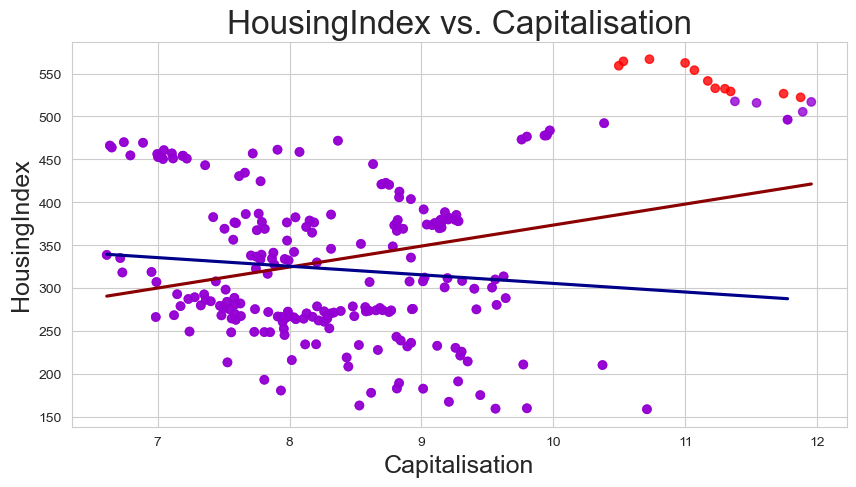

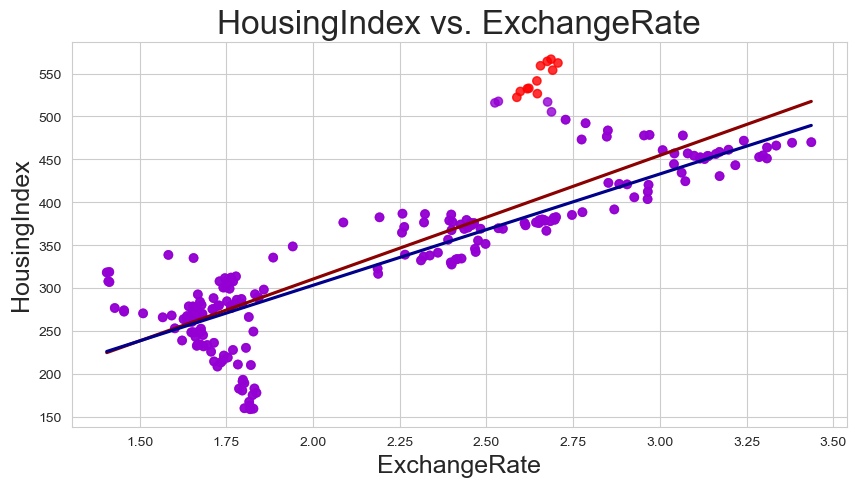

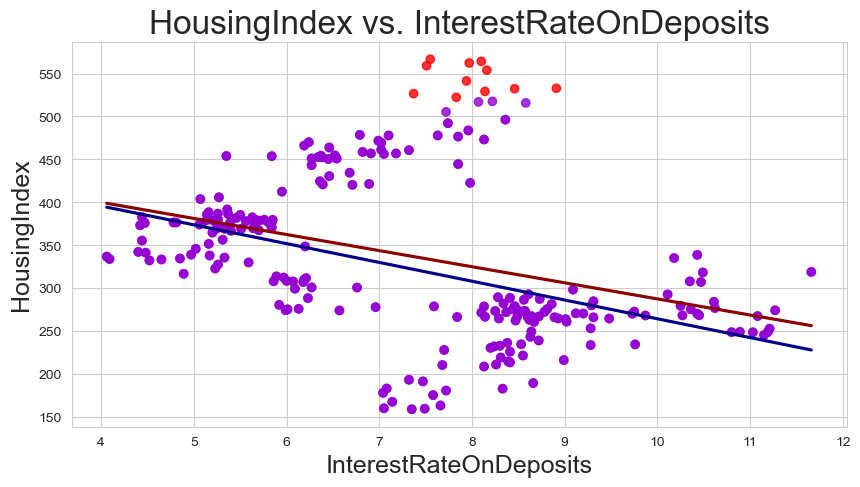

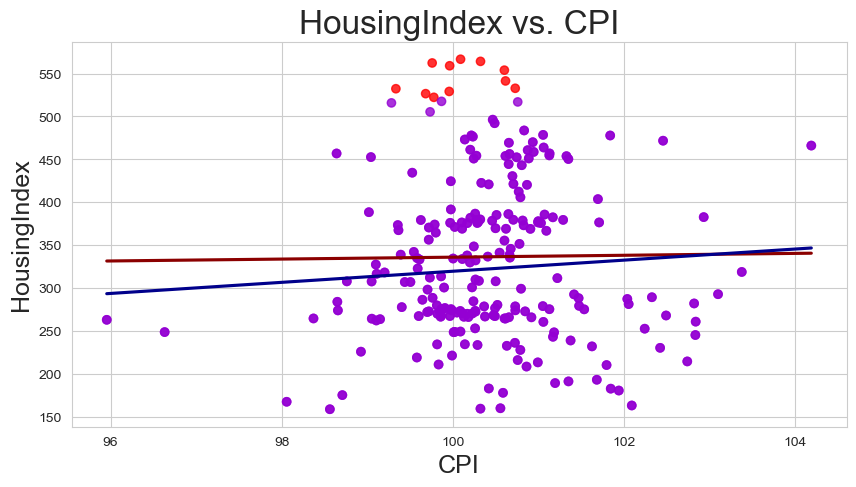

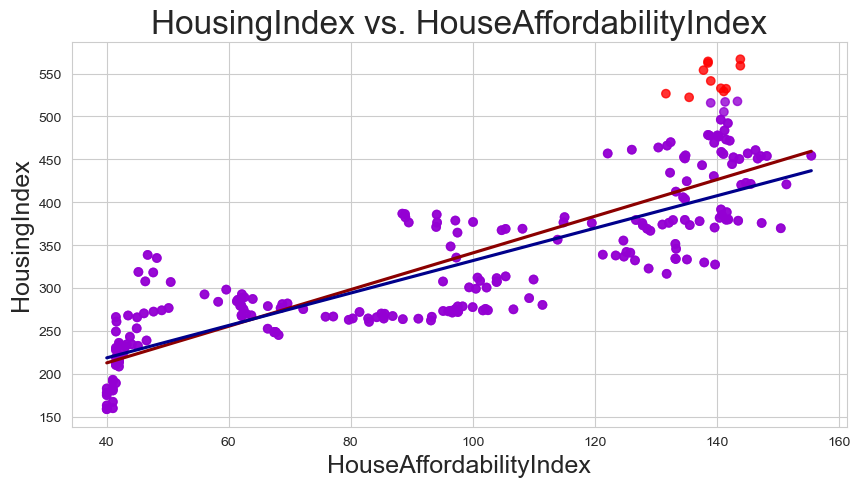

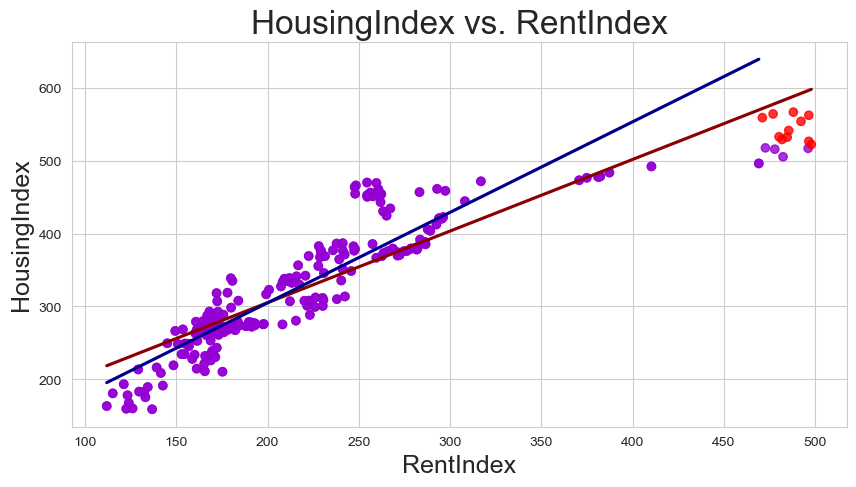

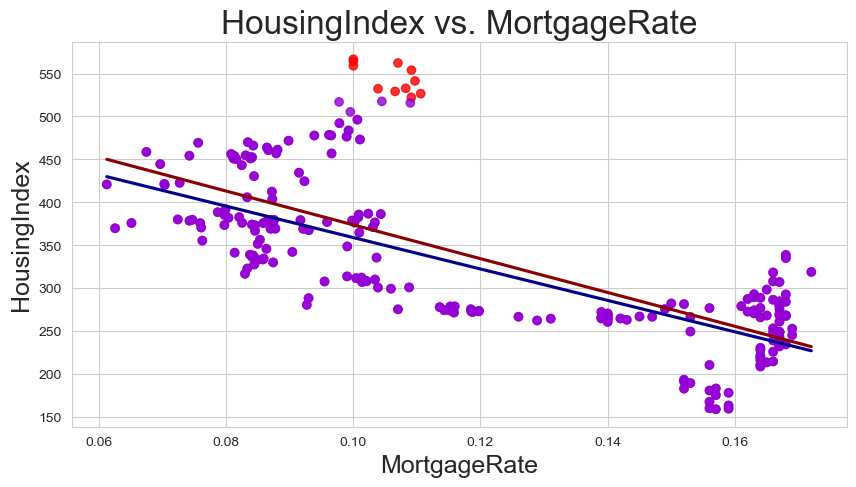

In [17]:
# Displays A Scatter Plot with Regression Line + Outliers in Red (Outliers are defined as >520 that is 98% percentile)

for col in cols_list:
    x_axis = col
    y_axis = 'HousingIndex'
    value = df_train[y_axis] > 520
    value2 = df_train[y_axis][:-15] > 520

    plt.figure(figsize=(10, 5))
    sns.regplot(x=df_train[x_axis], y=df_train[y_axis], fit_reg=True, ci = None,
                scatter_kws={'facecolors': np.where(value, "red", 'darkviolet'),
                             'edgecolor': np.where(value, "red", 'darkviolet')},
                line_kws={'color': 'darkred'})

    sns.regplot(x=df_train[x_axis][:-15], y=df_train[y_axis][:-15], fit_reg=True,ci = None,
                scatter_kws={'facecolors': np.where(value2, "red", 'darkviolet'),
                             'edgecolor': np.where(value2, "red", 'darkviolet')},
                line_kws={'color': 'darkblue'})

    plt.title('HousingIndex vs. {}'.format(x_axis), fontsize=24)
    plt.xlabel(x_axis, fontsize=18)
    plt.ylabel('HousingIndex', fontsize=18)
plt.show()


# XGBoost

## XGBoost - Data Preparation

In [18]:
df_train.head().round(2)

,HousingIndex,Capitalisation,ExchangeRate,InterestRateOnDeposits,CPI,HouseAffordabilityIndex,RentIndex,MortgageRate
Date,,,,,,,,
2005-01-01,163.43,8.53,1.82,7.66,102.09,40.0,111.90,0.16
2005-02-01,159.72,9.56,1.83,7.49,100.32,40.0,122.59,0.16
2005-03-01,178.20,8.62,1.84,7.04,100.59,40.0,123.29,0.16
2005-04-01,183.23,8.81,1.83,7.08,100.42,40.0,129.64,0.16
2005-05-01,175.51,9.45,1.83,7.58,98.71,40.0,133.09,0.16


## Hyperparameters Tunned XGBoost 

In [19]:
# Data split
y_full = df_train['HousingIndex'][:-15]
X_full = df_train.drop(columns=["HousingIndex"])[:-15]

y_test = df_train['HousingIndex'][-15:]
X_test = df_train.drop(columns=["HousingIndex"])[-15:]

In [20]:
best_params = {
    'max_depth': 4,
    'learning_rate': 0.004798,
    'n_estimators': 211,
    'gamma': 0.01531,
    'min_child_weight': 17,
    'subsample': 0.579605,
    'colsample_bytree': 0.821926,
    'reg_lambda': 2.039509e-07,
    'reg_alpha': 8.260234e-07
}

# Create XGBoost model with the specified parameters
model = XGBRegressor(**best_params, objective='reg:squarederror', random_state=123)

# Train the model on the full training data
model.fit(X_full, y_full)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test RMSE: {test_rmse}")


Test RMSE: 165.3115814870471


## Feature Importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

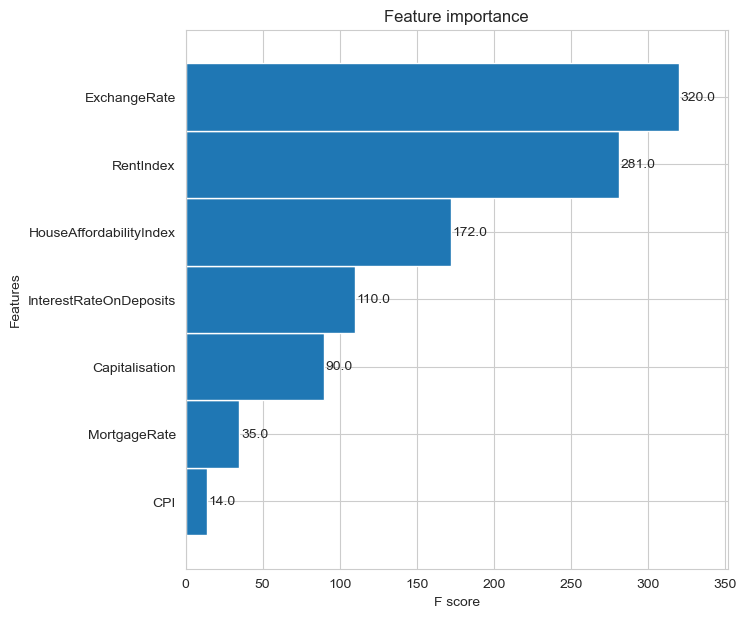

In [21]:
# Plot feature importance
figsize=(7,7)
fig, ax = plt.subplots(1,1,figsize=figsize)
plot_importance(model, ax=ax,height = 1)

## Prediction by XGBoost

In [22]:
# predict
full_predictions = model.predict(X_full).flatten()
test_predictions = model.predict(X_test).flatten()

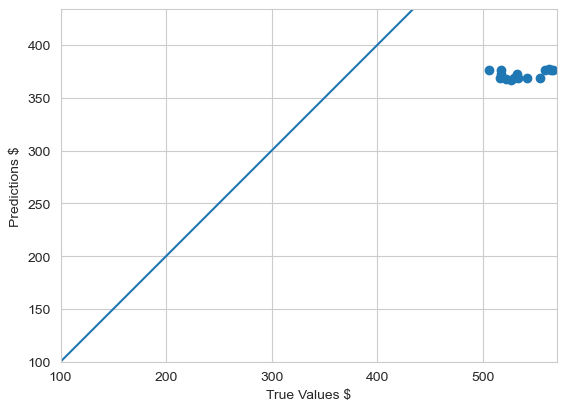

In [23]:
# scatter plot of True vs Predicted values - Test set
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values $')
plt.ylabel('Predictions $')
plt.axis('equal')
plt.axis('square')
plt.xlim([100,plt.xlim()[1]])
plt.ylim([100,plt.ylim()[1]])
_ = plt.plot([0, 1000], [0, 1000])



## XGboost - HousingIndex Prediction 

In [24]:
# For training & validation sets so called - X_full

In [25]:
c = pd.DataFrame([y_full], index = ['Date']).T.reset_index(drop=True)
c.rename(columns={'Date': 'date_full'}, inplace=True)
d = pd.DataFrame([full_predictions], index = ['Date']).T
d.rename(columns={'Date': 'date_full_prediction'}, inplace=True)

In [26]:
to_plot_full_data = pd.concat([c,d], axis = 1)

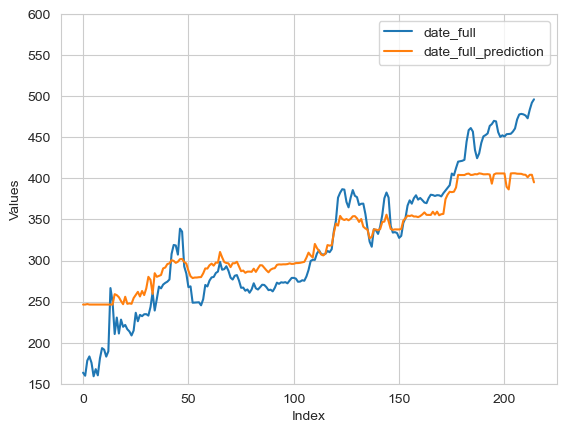

In [27]:
# Plot over index
plt.plot(to_plot_full_data.index, to_plot_full_data['date_full'], label='date_full')
plt.plot(to_plot_full_data.index, to_plot_full_data['date_full_prediction'], label='date_full_prediction')

# Set y-axis range
plt.ylim(150, 600)

# Add labels and legend
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()

# Show plot
plt.show()


In [28]:
# For Test set

In [29]:
a = pd.DataFrame([y_test], index = ['Date']).T.reset_index(drop=True)
a.rename(columns={'Date': 'date_test'}, inplace=True)
b = pd.DataFrame([test_predictions], index = ['Date']).T
b.rename(columns={'Date': 'date_prediction'}, inplace=True)

In [30]:
to_plot_data = pd.concat([a,b], axis = 1)
to_plot_data

,date_test,date_prediction
0,505.391378,376.532471
1,516.948317,376.383667
2,526.581209,367.048828
3,522.302736,367.658325
4,515.821737,368.522949
5,517.619202,372.599945
6,532.317906,372.599945
7,529.150824,368.522949
8,532.834361,368.579132
9,541.391305,368.644318


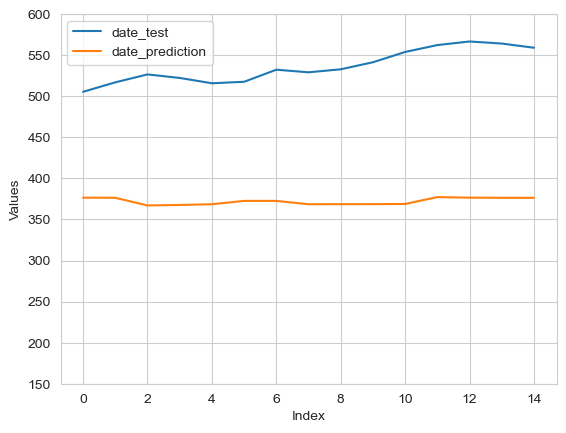

In [31]:
# Plot over index
plt.plot(to_plot_data.index, to_plot_data['date_test'], label='date_test')
plt.plot(to_plot_data.index, to_plot_data['date_prediction'], label='date_prediction')

# Set y-axis range
plt.ylim(150, 600)

# Add labels and legend
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()

# Show plot
plt.show()


In [32]:
# For Data Combined = full + test

In [33]:
# Rename columns to the same names
to_plot_full_data.columns = ['real', 'predict']
to_plot_data.columns = ['real', 'predict']

# Concatenating the dataframes vertically
concatenated_data = pd.concat([to_plot_full_data, to_plot_data], axis=0, ignore_index=True)
full_with_test = pd.DataFrame(concatenated_data)
full_with_test

,real,predict
0,163.432655,246.390869
1,159.721115,246.390869
2,178.196334,246.972549
3,183.228683,246.390869
4,175.511441,246.390869
...,...,...
225,553.941913,368.849304
226,562.321642,377.233459
227,566.672267,376.532471
228,564.176069,376.383667


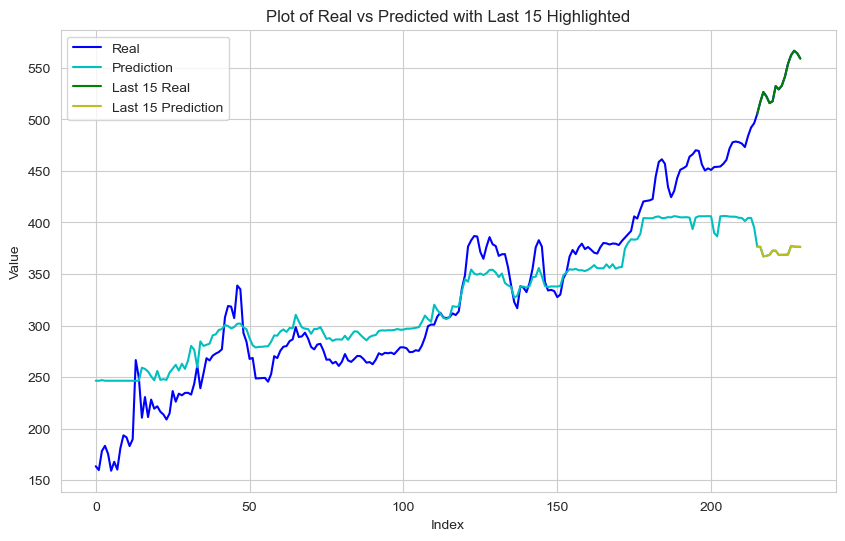

In [34]:
# Plotting the entire 'real' and 'predict' data
plt.figure(figsize=(10, 6))
plt.plot(full_with_test.index, full_with_test['real'], linestyle='-', color='b', label='Real')
plt.plot(full_with_test.index, full_with_test['predict'], linestyle='-', color='c', label='Prediction')

# Highlighting the last 15 values with different colors
last_15_real = full_with_test['real'].tail(15)
last_15_predict = full_with_test['predict'].tail(15)
last_15_index = full_with_test.index[-15:]

plt.plot(last_15_index, last_15_real, linestyle='-', color='g', label='Last 15 Real')
plt.plot(last_15_index, last_15_predict, linestyle='-', color='tab:olive', label='Last 15 Prediction')

# Adding title and labels
plt.title('Plot of Real vs Predicted with Last 15 Highlighted')
plt.xlabel('Index')
plt.ylabel('Value')

# Adding a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

## MSE of XGBoost

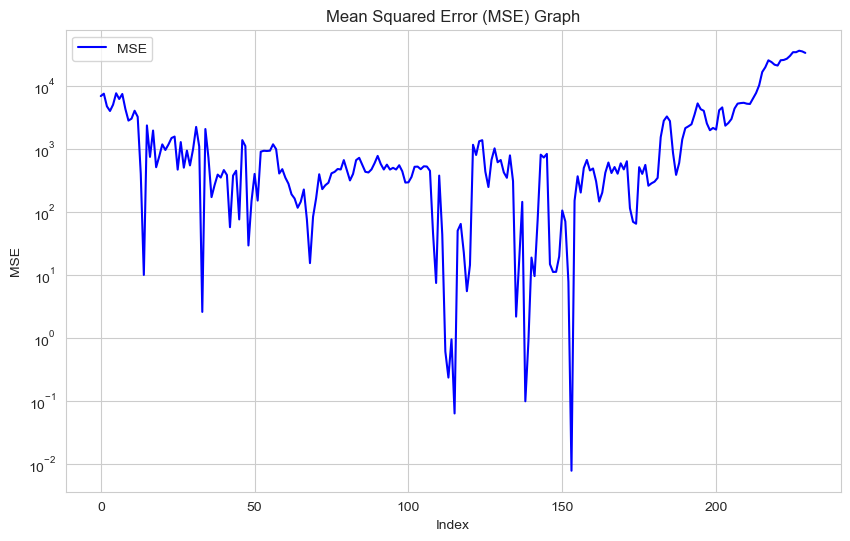

In [35]:
# Calculate MSE for each point
full_with_test['mse'] = (full_with_test['real'] - full_with_test['predict'])**2

# Plotting the MSE data with logarithmic y-axis
plt.figure(figsize=(10, 6))
plt.plot(full_with_test.index, full_with_test['mse'], linestyle='-', color='b', label='MSE')
plt.yscale('log')

# Adding title and labels
plt.title('Mean Squared Error (MSE) Graph')
plt.xlabel('Index')
plt.ylabel('MSE')

# Setting y-axis limits
plt.ylim=[1e-2,1e2]

# Adding a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

# LSTM Autoencoder

## LSTM - Data Preparation

In [36]:
# # Data normalization
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(df_train[:-15])
X_test = scaler.transform(df_train[-15:])

In [37]:
# Reshape for LSTM
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

## LSTM with Optimized Parameters

In [38]:
# Define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(19, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.000373))(inputs)
    L2 = LSTM(16, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(16, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(19, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [39]:
# Create the autoencoder model using MSE
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

2024-06-21 00:12:12.742499: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 8)]            0         
                                                                 
 lstm (LSTM)                 (None, 1, 19)             2128      
                                                                 
 lstm_1 (LSTM)               (None, 16)                2304      
                                                                 
 repeat_vector (RepeatVector  (None, 1, 16)            0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 1, 16)             2112      
                                                                 
 lstm_3 (LSTM)               (None, 1, 19)             2736      
                                                             

In [40]:
# Split data chronologically
split_index = int(len(X_train) * 0.8)  # 80% train, 20% validation
X_train_split = X_train[:split_index]
X_val_split = X_train[split_index:]

In [41]:
# Fit the model using the split data
history = model.fit(X_train_split, X_train_split, epochs=100, batch_size=10).history

Epoch 1/100
18/18 [==============================] - 4s 5ms/step - loss: 0.2156
Epoch 2/100
18/18 [==============================] - 0s 5ms/step - loss: 0.1974
Epoch 3/100
18/18 [==============================] - 0s 5ms/step - loss: 0.1787
Epoch 4/100
18/18 [==============================] - 0s 5ms/step - loss: 0.1584
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 0.1337
Epoch 6/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0963
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0582
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0489
Epoch 9/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0458
Epoch 10/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0447
Epoch 11/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0443
Epoch 12/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0439
Epoch 13/100
18/18 [=================

## Loss Analysis

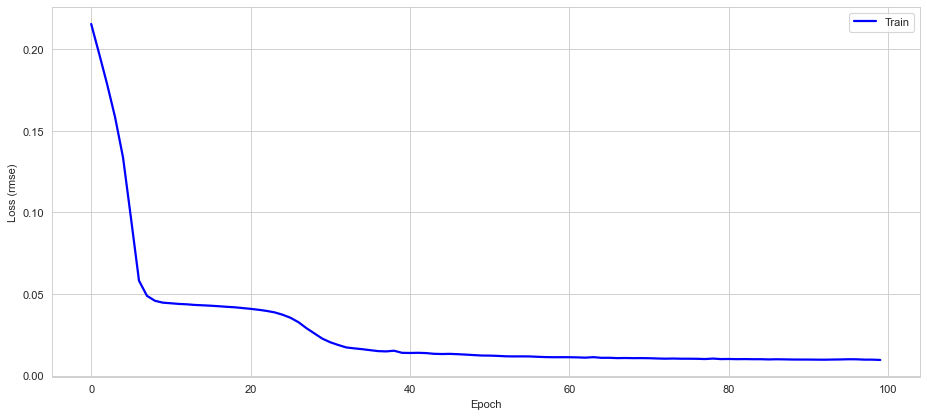

In [42]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
# ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_ylabel('Loss (rmse)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

7/7 [==============================] - 1s 2ms/step


/var/folders/fb/0f4v33f515vfq6921ss69f180000gn/T/ipykernel_38568/167453308.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored['Loss_rmse'], bins=20, kde=True, color='blue')


(0.0, 0.5)

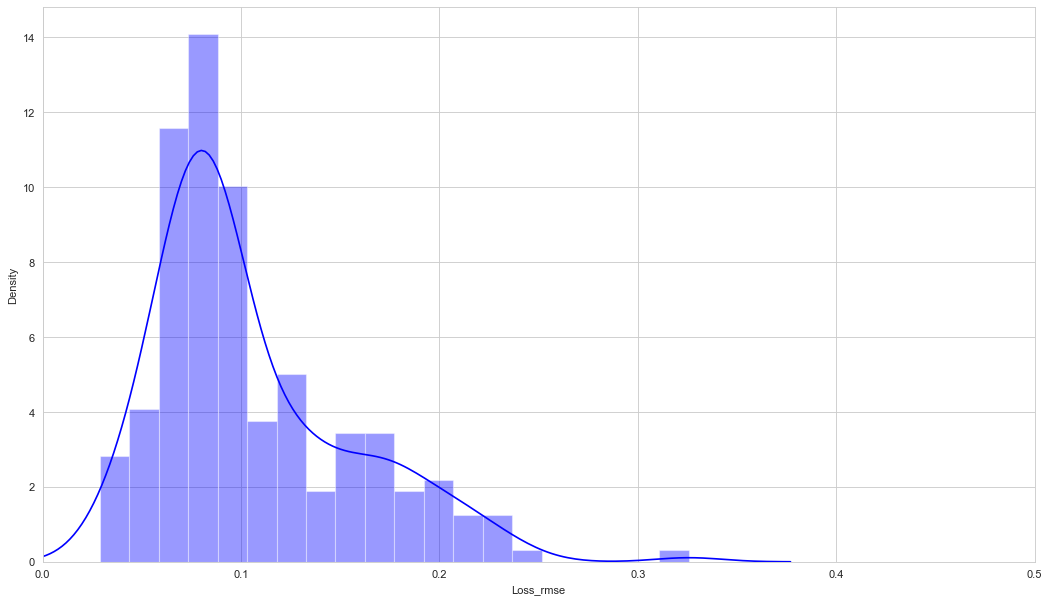

In [43]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=df_train.columns)
X_pred.index = df_train[:-15].index

scored = pd.DataFrame(index=df_train[:-15].index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_rmse'] = np.sqrt(np.mean((X_pred - Xtrain) ** 2, axis=1))
plt.figure(figsize=(16,9), dpi=80)
sns.distplot(scored['Loss_rmse'], bins=20, kde=True, color='blue')
plt.xlim([0.0, 0.5])

In [44]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=df_train.columns)
X_pred.index = df_train[-15:].index

scored = pd.DataFrame(index=df_train[-15:].index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_rmse'] = np.sqrt(np.mean((X_pred - Xtest) ** 2, axis=1))
scored['Threshold'] = 0.2
scored['Anomaly'] = scored['Loss_rmse'] > scored['Threshold']
scored.head()

1/1 [==============================] - 0s 26ms/step


,Loss_rmse,Threshold,Anomaly
Date,,,
2022-12-31,0.340231,0.2,True
2023-01-31,0.343771,0.2,True
2023-02-28,0.354131,0.2,True
2023-03-31,0.358770,0.2,True
2023-04-30,0.349298,0.2,True


In [45]:
# Calculate the same metrics for the training set +
# Merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=df_train[:-15].columns)
X_pred_train.index = df_train[:-15].index

scored_train = pd.DataFrame(index=df_train[:-15].index)
scored_train['Loss_rmse'] = np.sqrt(np.mean((X_pred_train - Xtrain) ** 2, axis=1))
scored_train['Threshold'] = 0.2
scored_train['Anomaly'] = scored_train['Loss_rmse'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])
scored

7/7 [==============================] - 0s 2ms/step


,Loss_rmse,Threshold,Anomaly
Date,,,
2005-01-01,0.147698,0.2,False
2005-02-01,0.152359,0.2,False
2005-03-01,0.126188,0.2,False
2005-04-01,0.122539,0.2,False
2005-05-01,0.137213,0.2,False
...,...,...,...
2023-10-31,0.325532,0.2,True
2023-11-30,0.338708,0.2,True
2023-12-31,0.312690,0.2,True


<Axes: xlabel='Date'>

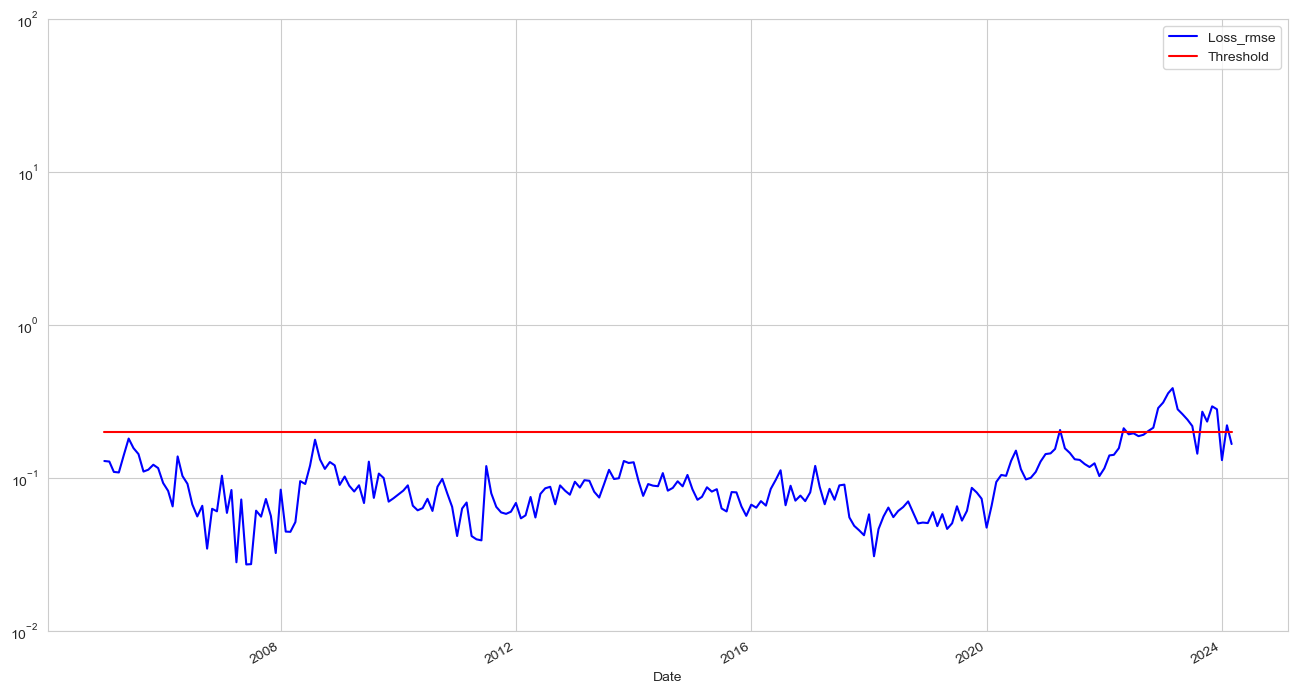

In [46]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])